In [411]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pickle

# Process json Files

In [412]:
FEATURE_COLUMNS = ['Status', 'Description', 'Comments', 'Priority', 'RootCause', 'Reporter', 
           'IssueKey', 'Summary', 'Sprint', 'Component', 'Application', 'Assigne']
def process_json_file(file_name, FEATURE_COLUMNS):
    f = open(file_name)
    Status = []
    Description = []
    Comments = []
    Priority = []
    RootCause = []
    Reporter = []
    IssueKey = []
    Summary = []
    Sprint = []
    Component = []
    Application = []
    Assigne = []
    data = json.load(f)
    for i in data:
        Status.append(i.get(FEATURE_COLUMNS[0], np.nan))
        Description.append(i.get(FEATURE_COLUMNS[1], np.nan))
        if len(i.get(FEATURE_COLUMNS[2], [])) !=0:
            Comments.append(i.get(FEATURE_COLUMNS[2], [np.nan])[0]['body'])
        else:
            Comments.append(np.nan)
        Priority.append(i.get(FEATURE_COLUMNS[3], np.nan))
        RootCause.append(i.get(FEATURE_COLUMNS[4], np.nan))
        Reporter.append(i.get(FEATURE_COLUMNS[5], np.nan))
        IssueKey.append(i.get(FEATURE_COLUMNS[6], np.nan))
        Summary.append(i.get(FEATURE_COLUMNS[7], np.nan))
        Sprint.append(i.get(FEATURE_COLUMNS[8], np.nan))
        Component.append(i.get(FEATURE_COLUMNS[9], np.nan))
        Application.append(i.get(FEATURE_COLUMNS[10], np.nan))
        Assigne.append(i.get(FEATURE_COLUMNS[11], np.nan))
    f.close()
    df = pd.DataFrame(data=Status, columns=['Status'])
    df['Description'] = Description
    df['Comments'] = Comments
    df['Priority'] = Priority
    df['RootCause'] = RootCause
    df['Reporter'] = Reporter
    df['IssueKey'] = IssueKey
    df['Summary'] = Summary
    df['Sprint'] = Sprint
    df['Component'] = Component
    df['Application'] = Application
    df['Assigne'] = Assigne
    return df

In [413]:
df_cancelled = process_json_file('cancelled.json', FEATURE_COLUMNS)
df_noncancelled = process_json_file('noncancelled.json', FEATURE_COLUMNS)

# Valid Invalid classification

In [414]:
df_valid = df_noncancelled.copy()
df_valid = df_valid[['Description', 'Priority', 'RootCause', 'Reporter', 'Application']]
df_valid['label'] = 1
df_invalid = df_cancelled.copy()
df_invalid = df_invalid[['Description', 'Priority', 'RootCause', 'Reporter', 'Application']]
df_invalid['label'] = 0
training_data = pd.concat([df_valid, df_invalid], axis=0)
training_data = training_data.sample(frac=1, random_state=1234)

# Cleaning

In [415]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
              "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
              "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
              "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's",
              "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my",
              "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same",
              "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them",
              "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through",
              "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when",
              "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll",
              "you're", "you've", "your", "yours", "yourself", "yourselves"]
def clean_description(x):
    #x = x.replace("\n", '').replace("\r", '').replace(".", '').replace("*", ' ').replace("*", ' ')
    x = re.sub("[!@#$\r\n.:0123456789\t-]", '', x)
    x = x.replace("*", ' ').replace(",", ' ').replace("[", '').replace("]", '').replace("|", '')
    arr = x.split()
    new_arr = [word for word in arr if not word in stopwords]
    sentence = ' '.join(word for word in new_arr)
    return sentence

In [416]:
training_data['Description'] = training_data['Description'].apply(clean_description)

# Parameters

In [417]:
num_words = 15000
oov_token = '<oov>'
#Define Max_len
max_len = 0
for descr in train_data['Description'].values:
    descr_len = len(descr.split())
    if descr_len > max_len:
        max_len = descr_len
#max_len = 700
padding = 'pre'
truncating = 'pre'
embedding_dim = 100

**Tokeize**

In [418]:
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(training_data['Description'].values)

# Data Prep

In [419]:
train_data = training_data.copy()
train_data, test_data = train_test_split(train_data, test_size=0.2)

#training_data = train_data
train_sentences = train_data['Description'].values
train_label = train_data['label'].values

test_sentences = test_data['Description'].values
test_label = test_data['label'].values

#Tokenize
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

#Pad sequences
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding=padding, truncating=truncating)
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding=padding, truncating=truncating)

# Model

In [420]:
def all_model(model_type):
    if model_type == 'dnn':
        inputs = tf.keras.layers.Input(shape=(max_len))
        x = tf.keras.layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_len)(inputs)
        x = tf.keras.layers.GlobalAveragePooling1D()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(512, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(1024, activation='relu')(x)
        #x = tf.keras.layers.Dropout(0.1)(x)
        out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    if model_type == 'rnn':
        inputs = tf.keras.layers.Input(shape=(max_len))
        x = tf.keras.layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_len)(inputs)
        x = tf.keras.layers.SimpleRNN(64, dropout=0.2)(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=out)
    return model
model = all_model('dnn')
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0004)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()

# Train

In [365]:
history = model.fit(train_padded, train_label, validation_data=(test_padded, test_label), batch_size=64, 
                    epochs=10, verbose=0)

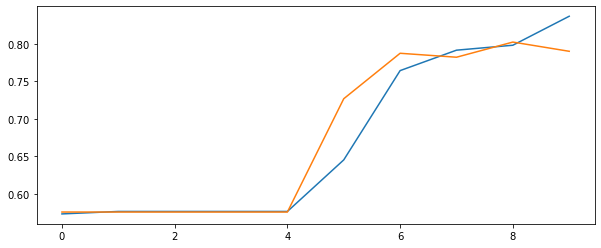

In [366]:
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Save Model

In [397]:
model.save("defect_classifier.h5")
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Prediction

In [425]:
model_loaded = tf.keras.models.load_model('defect_classifier.h5')
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer_loaded = pickle.load(handle)
    
pred_seq = tokenizer_loaded.texts_to_sequences([training_data['Description'].values[1]])
pred_padded = pad_sequences(pred_seq, maxlen=max_len, padding=padding, truncating=truncating)
model_loaded.predict(pred_padded)[0][0]

0.9020759

In [426]:
training_data['Description'].values[1]

"We app rejected Apple Please take look summary issues forwarded Apple They also available Apple Store Connect They still running issues logging Please let us know running point We like request keep us updated resolution progress Thank youWe discovered one bugs app reviewed iPad running iOS WiFiSpecifically app returns network error attempt register new account using Sign AppleWe noticed issue app still contributes lower quality user experience Apple users expect Your app uses Sign Apple login option not use Sign Apple button design branding and/or user interface elements appropriately described Sign With Apple Human Interface GuidelinesPS Image provided Appple Regards Begin forwarded messageFrom App Store Connect <no_replyemailapplecom>Subject New Message App Store Review Regarding Virgin VoyagesDate April AM EDTTo luisgonzalezvirginvoyagescom Dear Luis We've sent new message app Virgin Voyages app Apple ID To view reply message go Resolution Center App Store ConnectBest regards App S